In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}
import os, zipfile, io, re
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [30]:
image_size = 200
classes = ['male', 'female']
num_classes = len(classes)

In [31]:
%%time
# ZIP読み込み
z = zipfile.ZipFile('data/UTKFace.zip')
# 画像ファイルパスのみ取得
imgfiles = [ x for x in z.namelist() if re.search(r"^UTKFace.*jpg$", x)]

X = []
Y = []
for imgfile in imgfiles:
    # ZIPから画像読み込み
    image = Image.open(io.BytesIO(z.read(imgfile)))
    # RGB変換
    image = image.convert('RGB')
    # リサイズ
    image = image.resize((image_size, image_size))
    # 画像から配列に変換
    data = np.asarray(image)
    file = os.path.basename(imgfile)
    file_split = [i for i in file.split('_')]
    X.append(data)
    Y.append(file_split[1])
z.close()
del z, imgfiles

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(23697, 200, 200, 3) (23697,)
CPU times: user 19.4 s, sys: 684 ms, total: 20.1 s
Wall time: 19.9 s


In [32]:
# trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    random_state = 0,
    stratify = Y,
    test_size = 0.1
)
del X,Y
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21327, 200, 200, 3) (21327,) (2370, 200, 200, 3) (2370,)


In [33]:
# データ型の変換＆正規化
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
# one-hot変換
y_train = to_categorical(y_train, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

In [9]:
# trainデータからvalidデータを分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    random_state = 0,
    stratify = y_train,
    test_size = 0.2
)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape) 

(15165, 100, 100, 3) (15165, 2) (3792, 100, 100, 3) (3792, 2)


In [34]:
base_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

In [35]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

In [36]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

In [37]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1
)

# ModelCheckpoint
weights_dir = './weights/'
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    period = 3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3,
    verbose = 1
)

# log for TensorBoard
logging = TensorBoard(log_dir = "log/")

In [38]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

#108層までfreeze
for layer in model.layers[:108]:
    layer.trainable = False

    # Batch Normalizationのfreeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

#109層以降、学習させる
for layer in model.layers[108:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

In [39]:
%%time
hist = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = 32),
    steps_per_epoch = X_train.shape[0] // 32,
    epochs = 50,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping, reduce_lr, logging],
    shuffle = True,
    verbose = 1
)

Epoch 1/50
666/666 [==============================] - 313s 470ms/step - loss: 0.3132 - acc: 0.8633 - val_loss: 0.2686 - val_acc: 0.8945
Epoch 2/50
666/666 [==============================] - 311s 468ms/step - loss: 0.2238 - acc: 0.9073 - val_loss: 0.2853 - val_acc: 0.8992
Epoch 3/50
666/666 [==============================] - 311s 467ms/step - loss: 0.1921 - acc: 0.9238 - val_loss: 0.2614 - val_acc: 0.9118
Epoch 4/50
666/666 [==============================] - 311s 466ms/step - loss: 0.1705 - acc: 0.9342 - val_loss: 0.2006 - val_acc: 0.9211
Epoch 5/50
666/666 [==============================] - 310s 466ms/step - loss: 0.1541 - acc: 0.9389 - val_loss: 0.2080 - val_acc: 0.9338
Epoch 6/50
666/666 [==============================] - 310s 465ms/step - loss: 0.1405 - acc: 0.9459 - val_loss: 0.1957 - val_acc: 0.9249
Epoch 7/50
666/666 [==============================] - 310s 465ms/step - loss: 0.1269 - acc: 0.9510 - val_loss: 0.2106 - val_acc: 0.9241
Epoch 8/50
666/666 [============================

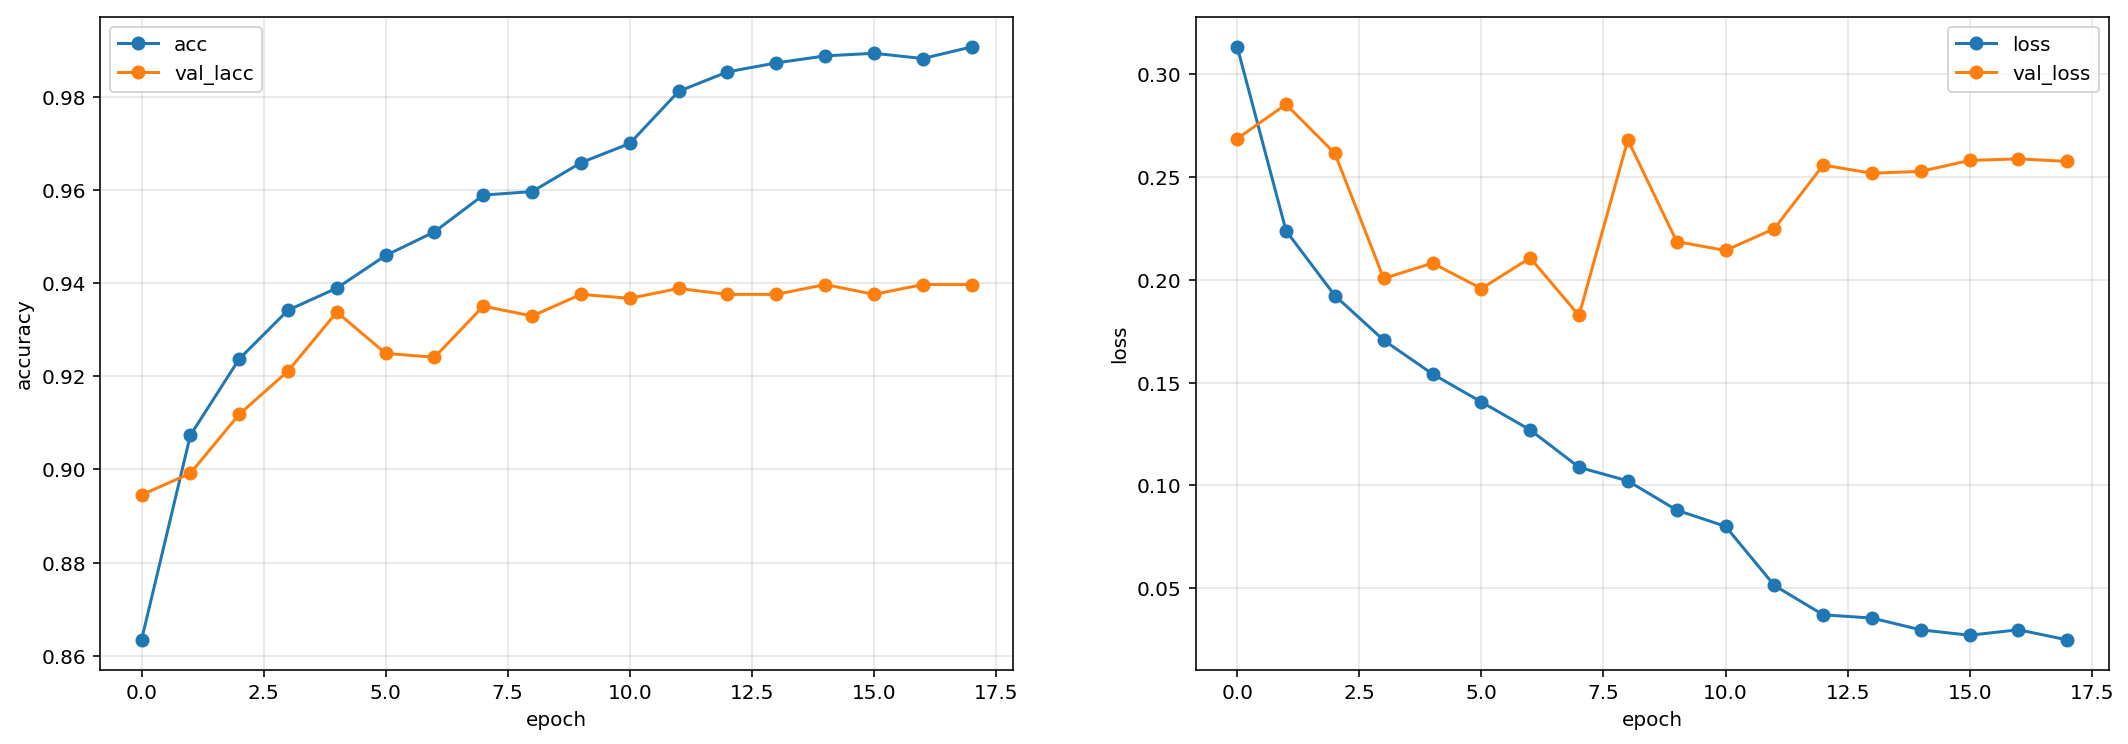

In [40]:
plt.figure(figsize=(18, 6))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["acc"], label="acc", marker = "o")
plt.plot(hist.history["val_acc"], label="val_lacc", marker="o")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc = "best")
plt.grid(color="gray", alpha=0.2)

#loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label="loss", marker="o")
plt.plot(hist.history["val_loss"], label="val_loss", marker="o")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc = "best")
plt.grid(color='gray', alpha=0.2)

plt.show()

In [41]:
score = model.evaluate(X_test, y_test, verbose=1)
print("evaluate loss : {[0]:.4f}".format(score))
print("evaluate loss : {[1]:.1%}".format(score))

2370/2370 [==============================] - ETA:  - 5s 2ms/step
evaluate loss : 0.2575
evaluate loss : 94.0%


In [42]:
model_dir = 'data/model/'
if os.path.exists(model_dir) == False:
    os.mkdir(model_dir)
    
model.save(model_dir + 'model.hdf5')

#model without an optimizer(it can be used only for prediction, not for training and evaluation)
model.save(model_dir + 'model-opt.hdf5', include_optimizer = False)

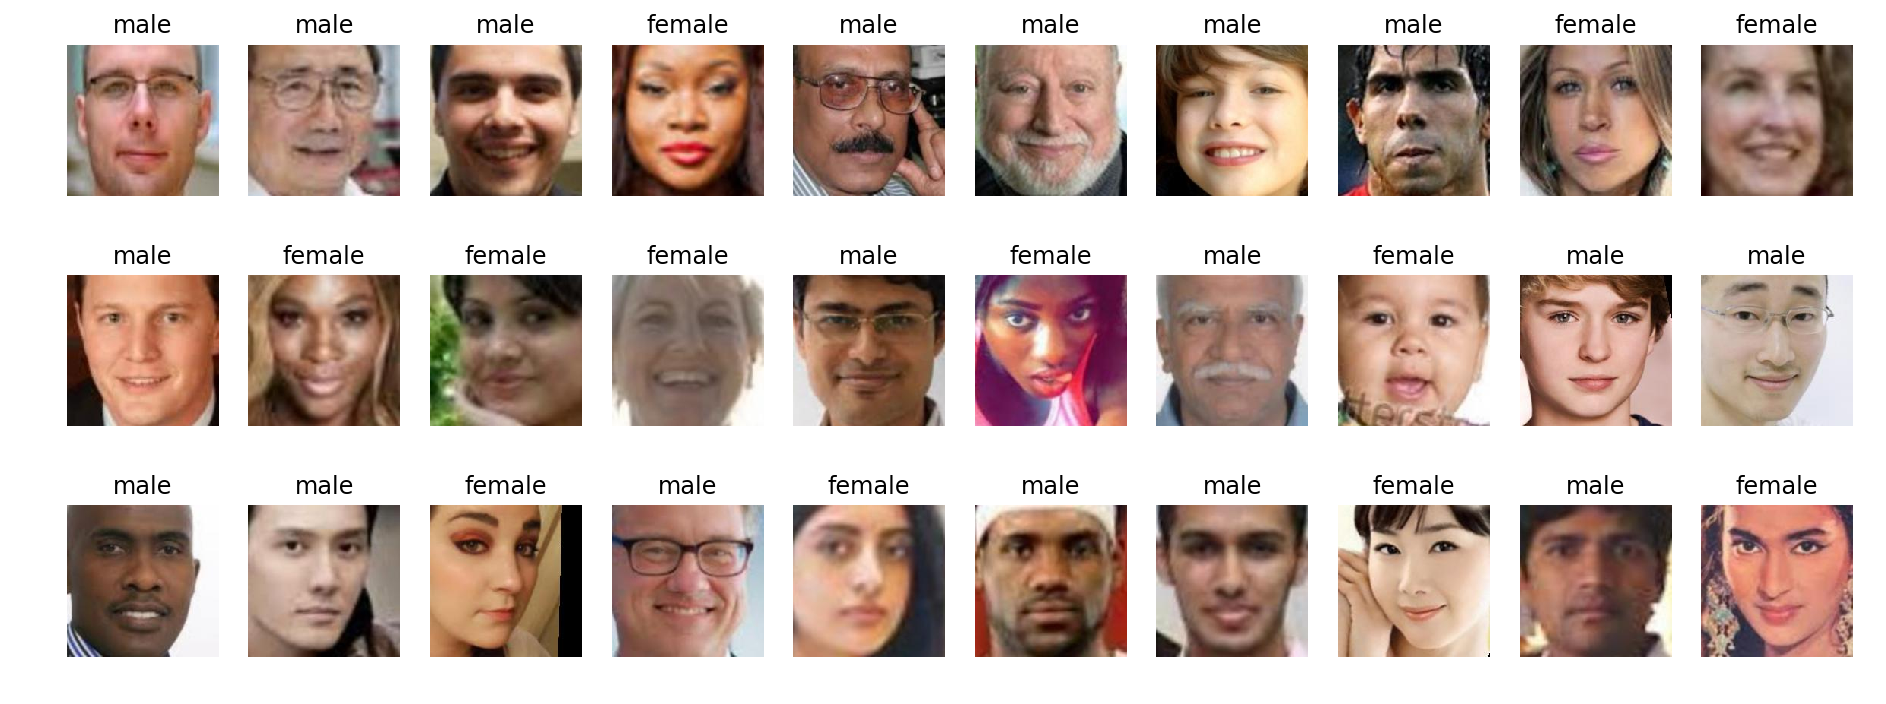

In [43]:
#show images for test data(first 30 data)
true_classes = np.argmax(y_test[0:30], axis=1)

plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    plt.title(classes[true_classes[i]])
    plt.imshow(X_test[i])
plt.show()

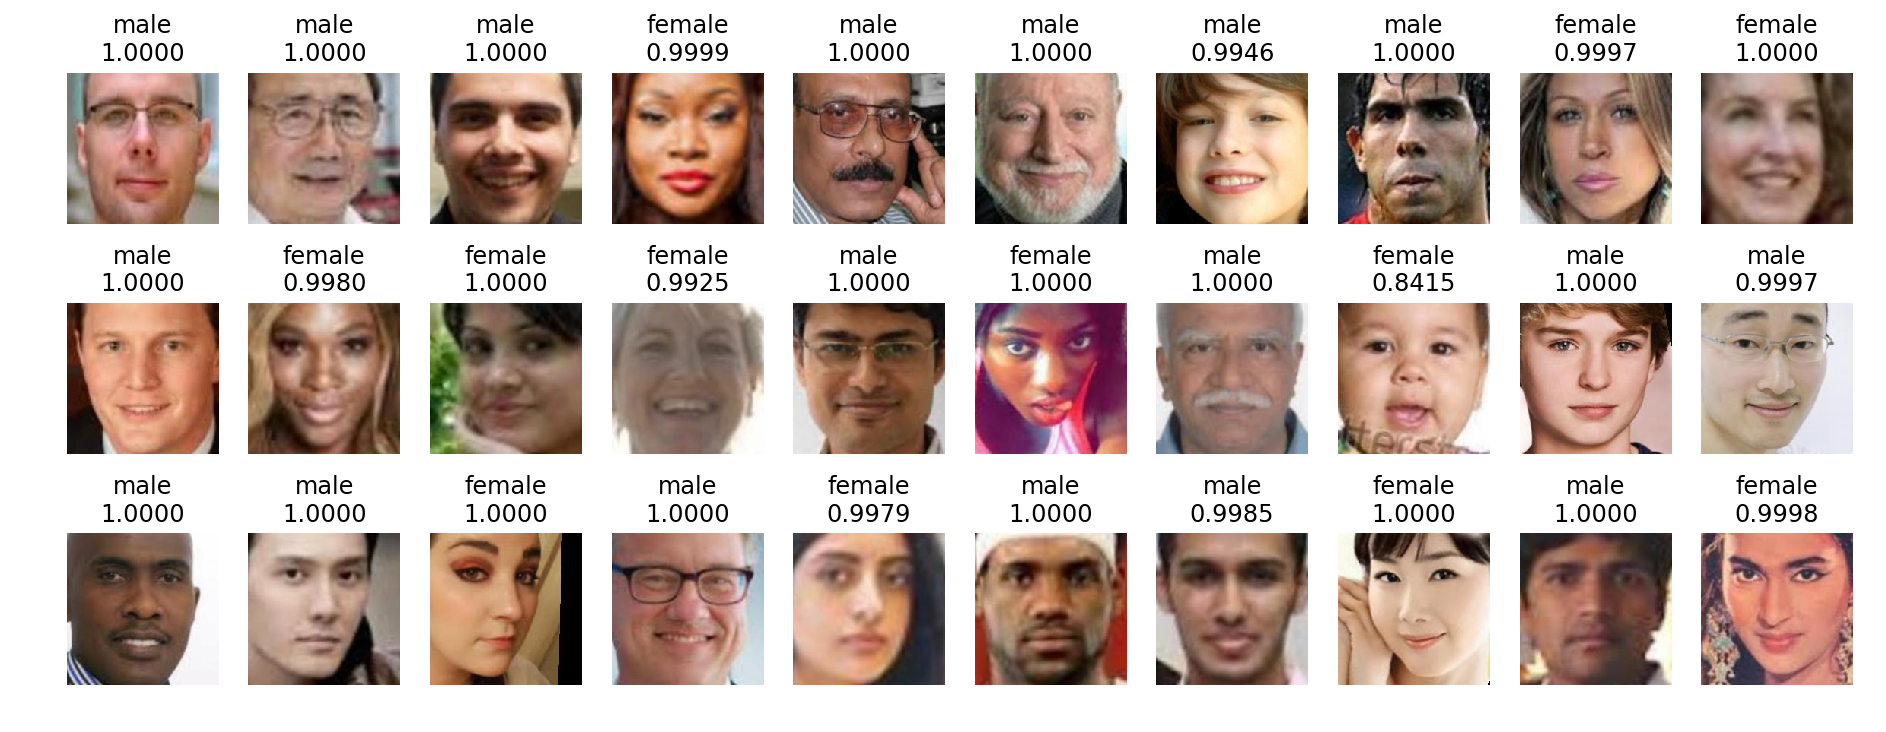

In [44]:
#show predicted results
pred_classes = np.argmax(model.predict(X_test[0:30]), axis = 1)

pred_probs = np.max(model.predict(X_test[0:30]), axis = 1)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    if pred_classes[i] == true_classes[i]:
        plt.title(classes[pred_classes[i]]+'\n'+pred_probs[i])
    else:
        plt.title(classes[pred_classes[i]]+'\n'+pred_probs[i], color="red")
    plt.imshow(X_test[i])
plt.show()

In [55]:
#labels for test data
true_classes = np.argmax(y_test, axis = 1)

#predicted value for test data
pred_classes = np.argmax(model.predict(X_test), axis = 1)

pred_probs = np.max(model.predict(X_test), axis = 1)
pred_probs = np.round(pred_probs, 2)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

In [56]:
#to check correct and incorrect data
correct = []
incorrect = []
incorrect_fname = []

for i in range(len(X_test)):
    if pred_classes[i] == true_classes[i]:
        correct.append((X_test[i], classes[pred_classes[i]], pred_probs[i]))
    else:
        incorrect.append((X_test[i], classes[pred_classes[i]], pred_probs[i]))
        incorrect_fname.append()
        
print("number of correct:", len(correct))
print("number of incorrect:", len(incorrect))

number of correct: 2227
number of incorrect: 143


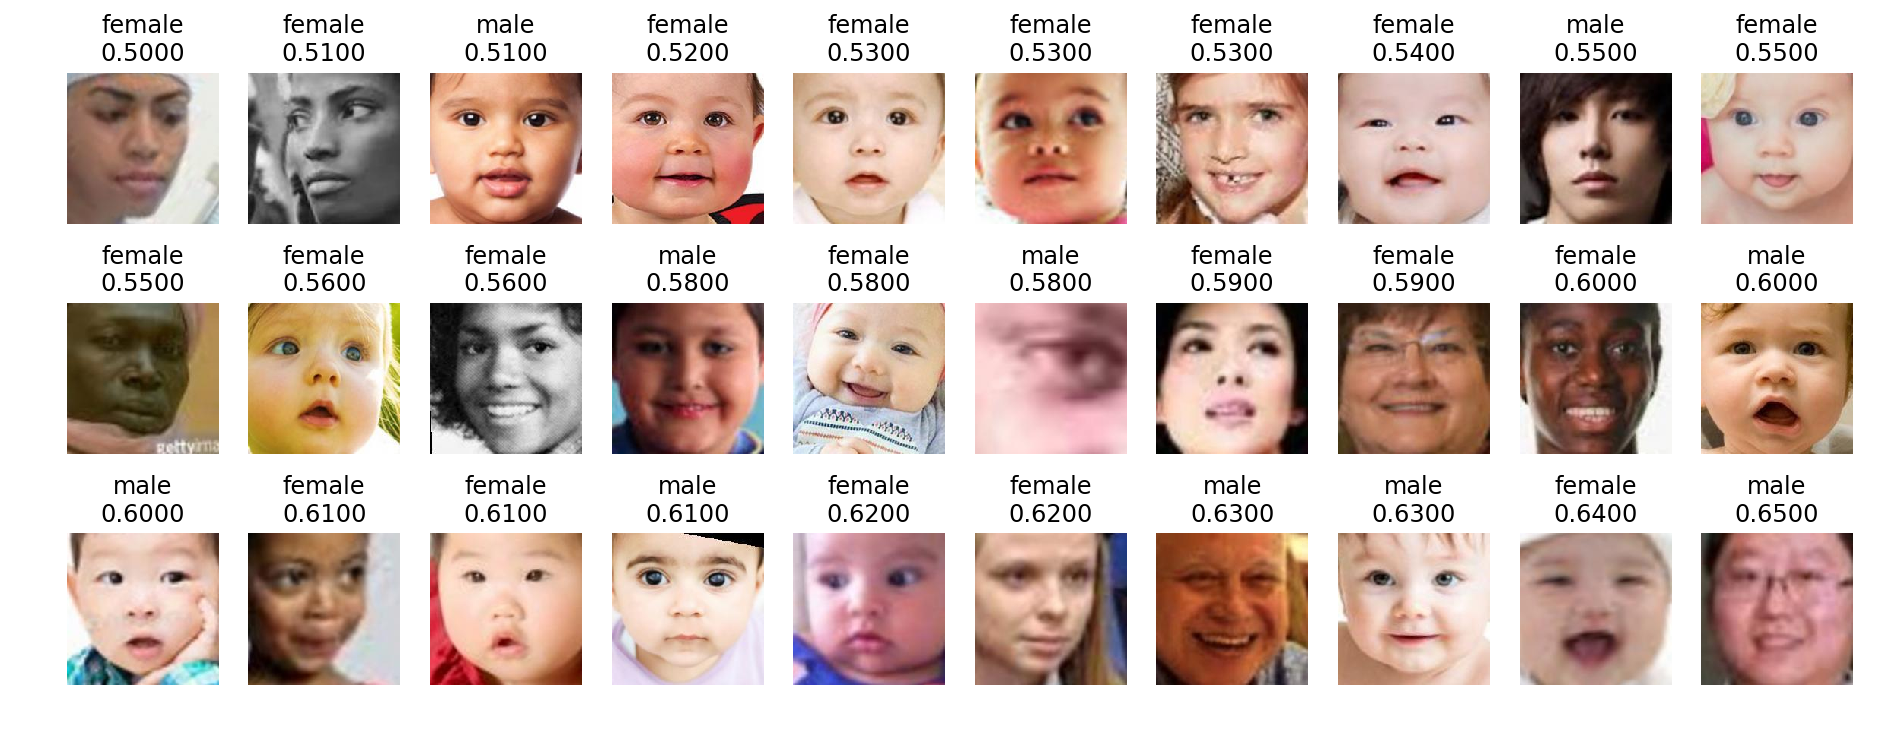

In [57]:
#x[2] means pred_probs[i] in the above case
correct.sort(key = lambda x:x[2])

plt.figure(figsize=(16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    plt.title(correct[i][1]+'\n'+correct[i][2])
    plt.imshow(correct[i][0])
plt.show()

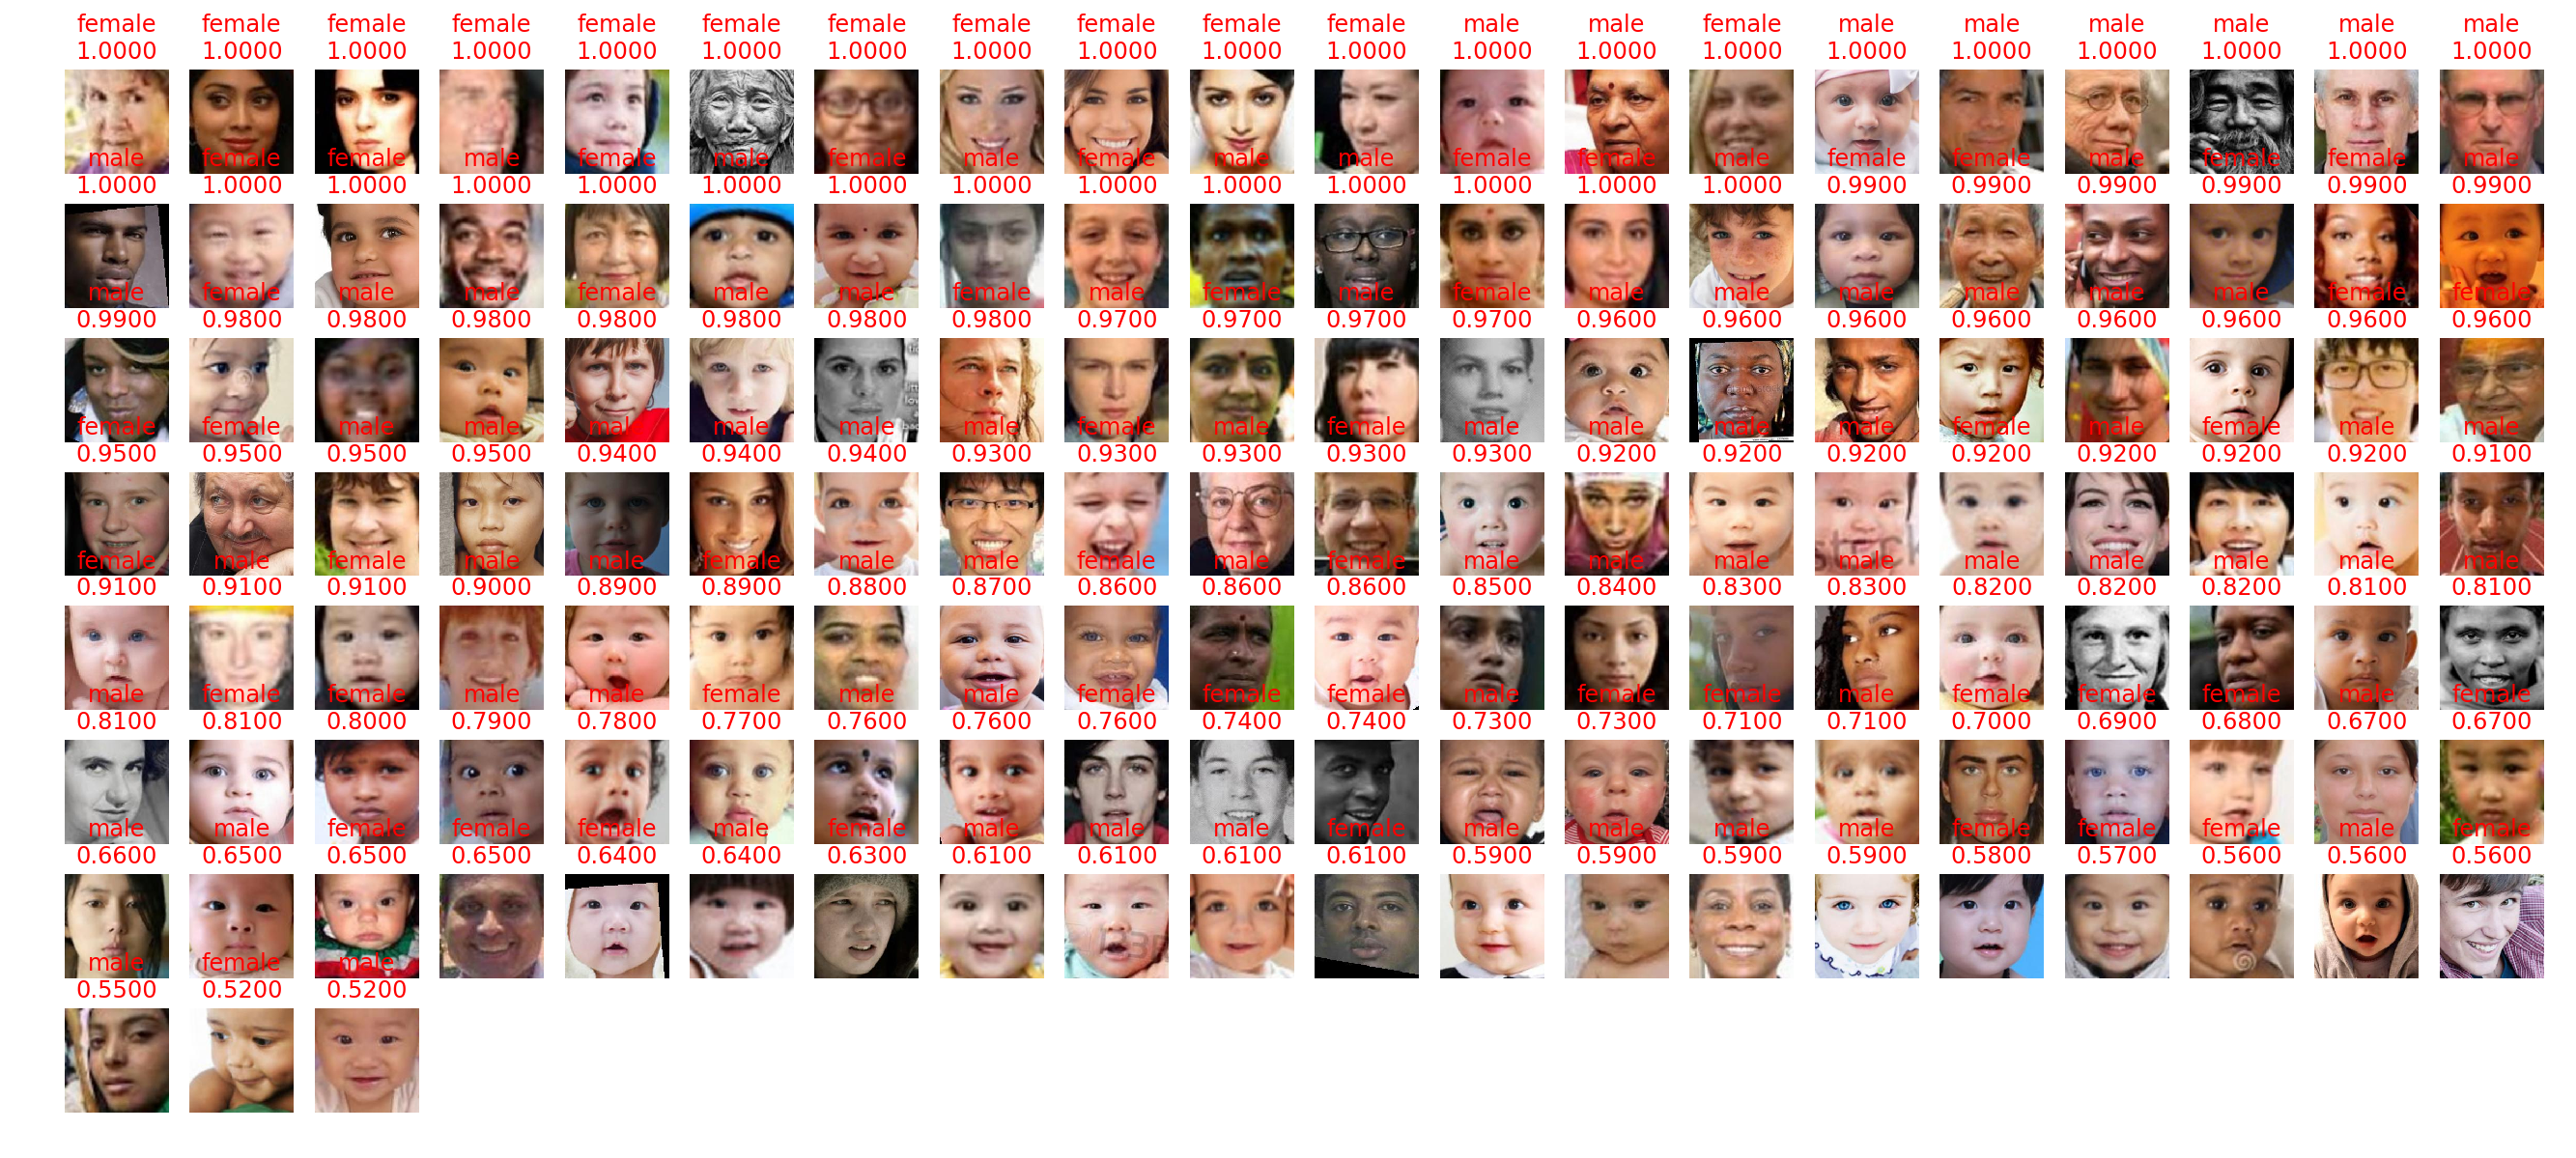

In [70]:
incorrect.sort(key = lambda x:x[2], reverse = True)

plt.figure(figsize = (23, 10))
for i in range(143):
    plt.subplot(8, 20, i + 1)
    plt.axis("off")
    plt.title(incorrect[i][1]+'\n'+incorrect[i][2], color='red')
    plt.imshow(incorrect[i][0])
plt.show()

In [59]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_classes, pred_classes)

array([[1176,   63],
       [  80, 1051]])

In [60]:
from sklearn.metrics import precision_score

precision_score(true_classes, pred_classes)

0.9434470377019749

In [61]:
from sklearn.metrics import recall_score

recall_score(true_classes, pred_classes)

0.9292661361626879

In [62]:
from sklearn.metrics import f1_score

f1_score(true_classes, pred_classes)

0.93630289532294

In [63]:
incorrect

[(array([[[0.8862745 , 0.81960785, 0.64705884],
          [0.8901961 , 0.8235294 , 0.6509804 ],
          [0.8901961 , 0.8235294 , 0.6509804 ],
          ...,
          [0.4509804 , 0.37254903, 0.26666668],
          [0.4627451 , 0.38431373, 0.2784314 ],
          [0.47058824, 0.39215687, 0.28627452]],
  
         [[0.89411765, 0.827451  , 0.654902  ],
          [0.89411765, 0.827451  , 0.654902  ],
          [0.89411765, 0.827451  , 0.654902  ],
          ...,
          [0.43529412, 0.35686275, 0.2509804 ],
          [0.44313726, 0.3647059 , 0.25882354],
          [0.4509804 , 0.37254903, 0.26666668]],
  
         [[0.89411765, 0.8392157 , 0.6627451 ],
          [0.89411765, 0.8392157 , 0.6627451 ],
          [0.89411765, 0.8352941 , 0.6666667 ],
          ...,
          [0.40392157, 0.3254902 , 0.21960784],
          [0.41568628, 0.3372549 , 0.23137255],
          [0.42352942, 0.34509805, 0.23921569]],
  
         ...,
  
         [[0.75686276, 0.67058825, 0.50980395],
          [0.7

In [54]:
len(X_test)

2370